In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, accuracy_score, f1_score, roc_auc_score

In [72]:
data = pd.read_csv("../data/loan_data.csv")

In [73]:
education_map = {'High School': 0, 'Associate': 1, 'Bachelor':2, 'Master':3, 'Doctorate':4}

data['person_education'] = data['person_education'].map(education_map)


hot_enc_cols = ['person_gender', 'person_home_ownership','loan_intent', 'previous_loan_defaults_on_file']
data = pd.get_dummies(data, columns=hot_enc_cols,drop_first=True)


to_fix_col = data.select_dtypes(include='bool').columns
data[to_fix_col] = data[to_fix_col].astype(int)


In [74]:
data.head(10)

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,22.0,3,71948.0,0,35000.0,16.02,0.49,3.0,561,1,0,0,0,1,0,0,0,1,0,0
1,21.0,0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,0,0,1,0,1,0,0,0,0,1
2,25.0,0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,0,0,0,0,0,0,1,0,0,0
3,23.0,2,79753.0,0,35000.0,15.23,0.44,2.0,675,1,0,0,0,1,0,0,1,0,0,0
4,24.0,3,66135.0,1,35000.0,14.27,0.53,4.0,586,1,1,0,0,1,0,0,1,0,0,0
5,21.0,0,12951.0,0,2500.0,7.14,0.19,2.0,532,1,0,0,1,0,0,0,0,0,1,0
6,26.0,2,93471.0,1,35000.0,12.42,0.37,3.0,701,1,0,0,0,1,1,0,0,0,0,0
7,24.0,0,95550.0,5,35000.0,11.11,0.37,4.0,585,1,0,0,0,1,0,0,1,0,0,0
8,24.0,1,100684.0,3,35000.0,8.90,0.35,2.0,544,1,0,0,0,1,0,0,0,1,0,0
9,21.0,0,12739.0,0,1600.0,14.74,0.13,3.0,640,1,0,0,1,0,0,0,0,0,1,0


In [75]:
data.describe()
print(data.isnull().sum())

person_age                            0
person_education                      0
person_income                         0
person_emp_exp                        0
loan_amnt                             0
loan_int_rate                         0
loan_percent_income                   0
cb_person_cred_hist_length            0
credit_score                          0
loan_status                           0
person_gender_male                    0
person_home_ownership_OTHER           0
person_home_ownership_OWN             0
person_home_ownership_RENT            0
loan_intent_EDUCATION                 0
loan_intent_HOMEIMPROVEMENT           0
loan_intent_MEDICAL                   0
loan_intent_PERSONAL                  0
loan_intent_VENTURE                   0
previous_loan_defaults_on_file_Yes    0
dtype: int64


In [76]:
scaler = StandardScaler()

In [77]:
train_data, test_data = train_test_split(data, test_size=0.4, random_state=456, stratify=data['loan_status'])

In [78]:
rate_threshold = train_data['loan_int_rate'].quantile(0.93)
percent_income_threshold = train_data['loan_percent_income'].quantile(0.93)
loan_amnt_threshold = train_data['loan_amnt'].quantile(0.93) 



forget = train_data[(train_data['loan_int_rate'] >= rate_threshold) | 
              (train_data['loan_percent_income'] >= percent_income_threshold) |
              (train_data['loan_amnt'] >= loan_amnt_threshold)]

X_forget = forget.drop(columns=['loan_status'])
Y_forget = forget['loan_status']
len(forget)

5412

In [79]:
target = LogisticRegression(max_iter=1000)

X = train_data.drop('loan_status', axis=1)
Y =train_data['loan_status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=456)

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

target.fit(X_train_scale, Y_train)

LogisticRegression(max_iter=1000)

In [80]:
unlearn_scaler = StandardScaler()

In [81]:
keep = train_data.drop(forget.index)


unlearn = LogisticRegression(max_iter=1000)

X_unlearn = keep.drop('loan_status', axis=1)
Y_unlearn =keep['loan_status']


X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(X_unlearn, Y_unlearn, test_size=.2, random_state=456)

X_train_unlearn_scale = unlearn_scaler.fit_transform(X_train_unlearn)
X_test_unlearn_scale = unlearn_scaler.transform(X_test_unlearn)

unlearn.fit(X_train_unlearn_scale , Y_train_unlearn)

LogisticRegression(max_iter=1000)

In [82]:
X_forget_scaled = unlearn_scaler.transform(X_forget)



predictions = target.predict(X_forget_scaled)
predictions_unlearn = unlearn.predict(X_forget_scaled)


print(f"Accuracy: {100*accuracy_score(Y_forget, predictions):.3f}")

print(f"F1: {100*f1_score(Y_forget, predictions, average='weighted'):.3f}")


print("\n")


print(f"Accuracy: {100*accuracy_score(Y_forget, predictions_unlearn):.3f}")

print(f"F1: {100*f1_score(Y_forget, predictions_unlearn, average='weighted'):.3f}")


print("Original model coef:", target.coef_)
print("Unlearned model coef:", unlearn.coef_)



Accuracy: 89.191
F1: 89.141


Accuracy: 83.851
F1: 83.751
Original model coef: [[ 9.89096142e-02  2.82542811e-02  4.37412051e-02 -1.21157277e-01
  -6.63774879e-01  9.62652712e-01  1.35203382e+00  1.92936931e-02
  -4.34940348e-01 -5.82123592e-03 -3.54043094e-03 -3.78023051e-01
   3.67883823e-01 -3.79195875e-01 -1.11671769e-02 -1.15792345e-01
  -2.67997896e-01 -4.69819797e-01 -4.29039110e+00]]
Unlearned model coef: [[ 1.63305319e-01  2.92008135e-02  6.81953066e-04 -1.34090770e-01
  -8.43426297e-01  7.45696016e-01  1.13925286e+00 -6.43009052e-02
  -4.18810057e-01 -1.13856364e-02 -4.24026858e-02 -3.85362800e-01
   1.47774465e-01 -3.04685208e-01  6.75437013e-02 -1.25871939e-01
  -1.79427834e-01 -4.57064570e-01 -3.98177530e+00]]


In [83]:
num_shadow_models = 5
chunks = int(len(test_data)/num_shadow_models)
shuffled_df = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
shadow_sets = []


for num in range(num_shadow_models):
    start_index = int(chunks*num)
    end_index = int(start_index+chunks)

    shadow_train, shadow_test = train_test_split(shuffled_df[start_index:end_index], test_size=.5, random_state=456)
    shadow_sets.append((shadow_train, shadow_test))

print(len(shadow_sets[4][1]))

1800


In [84]:
shadow_models = []
shadow_scaled_data = []
shadow_scalers =[]
for num in range(num_shadow_models):
    shadow_scaler = StandardScaler()
    
    shadow_train = shadow_sets[num][0]
    X_shadow_train = shadow_train.drop('loan_status', axis=1)
    Y_shadow_train = shadow_train['loan_status']
    X_shadow_train_scaled = shadow_scaler.fit_transform(X_shadow_train)

    i = LogisticRegression(max_iter=1000)
    i.fit(X_shadow_train_scaled, Y_shadow_train )
    print("shadow model " + str(num) + " trained")

    shadow_scalers.append(shadow_scaler)
    shadow_scaled_data.append((X_shadow_train_scaled,Y_shadow_train))
    shadow_models.append((i))


shadow model 0 trained
shadow model 1 trained
shadow model 2 trained
shadow model 3 trained
shadow model 4 trained


In [85]:
member_feature= []
member_label = []

for num in range(num_shadow_models):

    model = shadow_models[num]
    scaled_data = shadow_scaled_data[num][0]
    Y_data = shadow_scaled_data[num][1]

    results = model.predict_proba(scaled_data)

    max_confidence = np.max(results, axis=1)
    entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
    predictions = model.predict(scaled_data)
    true_class_proba = results[np.arange(len(Y_data)), Y_data]
    correctness = (predictions == Y_data).astype(int)
    loss = -np.log(true_class_proba + 1e-8)

    attack_features = np.column_stack([
        max_confidence,
        entropy, 
        true_class_proba,
        loss,
        correctness,
    ])
    
    member_feature.append(attack_features)
    member_label.append(np.ones(len(attack_features)))


In [86]:
non_member_feature= []
non_member_label = []

for num in range(num_shadow_models):

    model = shadow_models[num]
    test_set = shadow_sets[num][1]
    scaler = shadow_scalers[num]

    X_test = test_set.drop('loan_status', axis=1)
    Y_data_test = test_set['loan_status']
    X_test_scaled = scaler.fit_transform(X_test)

    results = model.predict_proba(X_test_scaled)


    max_confidence = np.max(results, axis=1)
    entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
    predictions = model.predict(X_test_scaled)
    true_class_proba = results[np.arange(len(Y_data_test)), Y_data_test]
    correctness = (predictions == Y_data_test).astype(int)
    loss = -np.log(true_class_proba + 1e-8)

    attack_features = np.column_stack([
        max_confidence,
        entropy, 
        true_class_proba,
        loss,
        correctness,
    ])

    non_member_feature.append(attack_features)
    non_member_label.append(np.zeros(len(attack_features)))



In [87]:
X_attack = np.vstack(member_feature + non_member_feature)
y_attack = np.hstack(member_label + non_member_label)

In [88]:
attack_scaler = StandardScaler()

X_attack_scale = attack_scaler.fit_transform(X_attack)

attack = LogisticRegression(max_iter=1000)
attack.fit(X_attack_scale, y_attack)


LogisticRegression(max_iter=1000)

In [89]:
target_results = target.predict_proba(X_forget_scaled)

max_confidence = np.max(target_results, axis=1)
entropy = -np.sum(target_results * np.log(target_results + 1e-8), axis=1)
target_predictions = target.predict(X_forget_scaled)
true_class_proba = target_results[np.arange(len(Y_forget)), Y_forget]
correctness = (target_predictions == Y_forget).astype(int)
loss = -np.log(true_class_proba + 1e-8)

target_attack_features = np.column_stack([
        max_confidence,
        entropy, 
        true_class_proba,
        loss,
        correctness,
    ])

target_attack_features_scaled = attack_scaler.transform(target_attack_features)

In [90]:
unlearn_results = unlearn.predict_proba(X_forget_scaled)

max_confidence = np.max(unlearn_results, axis=1)
entropy = -np.sum(unlearn_results * np.log(unlearn_results + 1e-8), axis=1)
unlearn_predictions = unlearn.predict(X_forget_scaled)
true_class_proba = unlearn_results[np.arange(len(Y_forget)), Y_forget]
correctness = (unlearn_predictions == Y_forget).astype(int)
loss = -np.log(true_class_proba + 1e-8)

unlearn_attack_features = np.column_stack([
        max_confidence,
        entropy, 
        true_class_proba,
        loss,
        correctness,
    ])

unlearn_attack_features_scaled = attack_scaler.transform(unlearn_attack_features)

In [91]:
target_attack_predictions = attack.predict(target_attack_features_scaled)
target_attack_accuracy = accuracy_score(np.ones(len(target_attack_predictions)), target_attack_predictions)

In [92]:
unlearn_attack_predictions = attack.predict(unlearn_attack_features_scaled)
unlearn_attack_accuracy = accuracy_score(np.zeros(len(unlearn_attack_predictions)), unlearn_attack_predictions)

In [93]:
print(target_attack_accuracy)
print(unlearn_attack_accuracy)

0.6282335550628233
0.4874353288987435


In [94]:
def calculate_model_metrics(model, X_scaled, y_true, model_name):
    
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)[:, 1]  
    
    metrics = {
        f'{model_name}_accuracy': accuracy_score(y_true, predictions),
        f'{model_name}_f1': f1_score(y_true, predictions),
        f'{model_name}_auc': roc_auc_score(y_true, probabilities)
    }
    
    return metrics

In [95]:
def run_pipeline(config):
    scaler = StandardScaler()
    train_data, test_data = train_test_split(data, test_size=0.4, random_state=456, stratify=data['loan_status'])
    rate_threshold = train_data['loan_int_rate'].quantile(config['forget_percentile'])
    rate_threshold = train_data['loan_int_rate'].quantile(config['forget_percentile'])
    loan_amnt_threshold = train_data['loan_amnt'].quantile(0.93) 



    forget = train_data[(train_data['loan_int_rate'] >= rate_threshold) | 
                (train_data['loan_percent_income'] >= percent_income_threshold) |
                (train_data['loan_amnt'] >= loan_amnt_threshold)]

    X_forget = forget.drop(columns=['loan_status'])
    Y_forget = forget['loan_status']
    len(forget)
    target = LogisticRegression(max_iter=1000)

    X = train_data.drop('loan_status', axis=1)
    Y =train_data['loan_status']

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=456)

    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)

    target.fit(X_train_scale, Y_train)
    unlearn_scaler = StandardScaler()
    keep = train_data.drop(forget.index)


    unlearn = LogisticRegression(max_iter=1000)

    X_unlearn = keep.drop('loan_status', axis=1)
    Y_unlearn =keep['loan_status']


    X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(X_unlearn, Y_unlearn, test_size=.2, random_state=456)

    X_train_unlearn_scale = unlearn_scaler.fit_transform(X_train_unlearn)
    X_test_unlearn_scale = unlearn_scaler.transform(X_test_unlearn)

    unlearn.fit(X_train_unlearn_scale , Y_train_unlearn)
    X_forget_scaled = unlearn_scaler.transform(X_forget)



    predictions = target.predict(X_forget_scaled)
    predictions_unlearn = unlearn.predict(X_forget_scaled)

    '''print(f"Accuracy: {100*accuracy_score(Y_forget, predictions):.3f}")

    print(f"F1: {100*f1_score(Y_forget, predictions, average='weighted'):.3f}")


    print("\n")


    print(f"Accuracy: {100*accuracy_score(Y_forget, predictions_unlearn):.3f}")

    print(f"F1: {100*f1_score(Y_forget, predictions_unlearn, average='weighted'):.3f}")


    print("Original model coef:", target.coef_)
    print("Unlearned model coef:", unlearn.coef_)'''
    num_shadow_models = 5
    chunks = int(len(test_data)/num_shadow_models)
    shuffled_df = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
    shadow_sets = []


    for num in range(num_shadow_models):
        start_index = int(chunks*num)
        end_index = int(start_index+chunks)

        shadow_train, shadow_test = train_test_split(shuffled_df[start_index:end_index], test_size=.5, random_state=456)
        shadow_sets.append((shadow_train, shadow_test))

    #print(len(shadow_sets[4][1]))
    shadow_models = []
    shadow_scaled_data = []
    shadow_scalers =[]
    for num in range(num_shadow_models):
        shadow_scaler = StandardScaler()
        
        shadow_train = shadow_sets[num][0]
        X_shadow_train = shadow_train.drop('loan_status', axis=1)
        Y_shadow_train = shadow_train['loan_status']
        X_shadow_train_scaled = shadow_scaler.fit_transform(X_shadow_train)

        i = LogisticRegression(max_iter=1000)
        i.fit(X_shadow_train_scaled, Y_shadow_train )
       # print("shadow model " + str(num) + " trained")

        shadow_scalers.append(shadow_scaler)
        shadow_scaled_data.append((X_shadow_train_scaled,Y_shadow_train))
        shadow_models.append((i))
    member_feature= []
    member_label = []

    for num in range(num_shadow_models):

        model = shadow_models[num]
        scaled_data = shadow_scaled_data[num][0]
        Y_data = shadow_scaled_data[num][1]

        results = model.predict_proba(scaled_data)

        max_confidence = np.max(results, axis=1)
        entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
        predictions = model.predict(scaled_data)
        true_class_proba = results[np.arange(len(Y_data)), Y_data]
        correctness = (predictions == Y_data).astype(int)
        loss = -np.log(true_class_proba + 1e-8)

        attack_features = np.column_stack([
            max_confidence,
            entropy, 
            true_class_proba,
            loss,
            correctness,
        ])
        
        member_feature.append(attack_features)
        member_label.append(np.ones(len(attack_features)))
    non_member_feature= []
    non_member_label = []

    for num in range(num_shadow_models):

        model = shadow_models[num]
        test_set = shadow_sets[num][1]
        scaler = shadow_scalers[num]

        X_test = test_set.drop('loan_status', axis=1)
        Y_data_test = test_set['loan_status']
        X_test_scaled = scaler.fit_transform(X_test)

        results = model.predict_proba(X_test_scaled)


        max_confidence = np.max(results, axis=1)
        entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
        predictions = model.predict(X_test_scaled)
        true_class_proba = results[np.arange(len(Y_data_test)), Y_data_test]
        correctness = (predictions == Y_data_test).astype(int)
        loss = -np.log(true_class_proba + 1e-8)

        attack_features = np.column_stack([
            max_confidence,
            entropy, 
            true_class_proba,
            loss,
            correctness,
        ])

        non_member_feature.append(attack_features)
        non_member_label.append(np.zeros(len(attack_features)))

    X_attack = np.vstack(member_feature + non_member_feature)
    y_attack = np.hstack(member_label + non_member_label)
    attack_scaler = StandardScaler()

    X_attack_scale = attack_scaler.fit_transform(X_attack)

    attack_pip = LogisticRegression(max_iter=1000)
    target_results = target.predict_proba(X_forget_scaled)


    max_confidence = np.max(target_results, axis=1)
    entropy = -np.sum(target_results * np.log(target_results + 1e-8), axis=1)
    target_predictions = target.predict(X_forget_scaled)
    true_class_proba = target_results[np.arange(len(Y_forget)), Y_forget]
    correctness = (target_predictions == Y_forget).astype(int)
    loss = -np.log(true_class_proba + 1e-8)

    target_attack_features = np.column_stack([
            max_confidence,
            entropy, 
            true_class_proba,
            loss,
            correctness,
        ])

    target_attack_features_scaled = attack_scaler.transform(target_attack_features)
    unlearn_results = unlearn.predict_proba(X_forget_scaled)

    max_confidence = np.max(unlearn_results, axis=1)
    entropy = -np.sum(unlearn_results * np.log(unlearn_results + 1e-8), axis=1)
    unlearn_predictions = unlearn.predict(X_forget_scaled)
    true_class_proba = unlearn_results[np.arange(len(Y_forget)), Y_forget]
    correctness = (unlearn_predictions == Y_forget).astype(int)
    loss = -np.log(true_class_proba + 1e-8)

    unlearn_attack_features = np.column_stack([
            max_confidence,
            entropy, 
            true_class_proba,
            loss,
            correctness,
        ])
    
    attack_pip.fit(X_attack_scale, y_attack)

    retain_metrics_original = calculate_model_metrics(target, X_test_scale, Y_test, 'original_retain')
    retain_metrics_unlearned = calculate_model_metrics(unlearn, X_test_unlearn_scale, Y_test_unlearn, 'unlearned_retain')
    forget_metrics_original = calculate_model_metrics(target, scaler.transform(X_forget), Y_forget, 'original_forget')
    forget_metrics_unlearned = calculate_model_metrics(unlearn, X_forget_scaled, Y_forget, 'unlearned_forget')
    

    unlearn_attack_features_scaled = attack_scaler.transform(unlearn_attack_features)
    target_attack_predictions = attack_pip.predict(target_attack_features_scaled)
    target_attack_accuracy = accuracy_score(np.ones(len(target_attack_predictions)), target_attack_predictions)
    unlearn_attack_predictions = attack_pip.predict(unlearn_attack_features_scaled)
    unlearn_attack_accuracy = accuracy_score(np.zeros(len(unlearn_attack_predictions)), unlearn_attack_predictions)
    
    
    return {
        'attack_model': attack_pip,
        'attack_scaler': attack_scaler,
        'target_model': target,
        'unlearned_model': unlearn,
        'target_attack_features_scaled': target_attack_features_scaled,
        'forget_set': forget,
        'target_accuracy':target_attack_accuracy,
        'unlearn_accuracy':unlearn_attack_accuracy,
        'retain_metrics_original': retain_metrics_original,
        'retain_metrics_unlearned': retain_metrics_unlearned,
        'forget_metrics_original': forget_metrics_original,
        'forget_metrics_unlearned': forget_metrics_unlearned
    }

In [96]:
scenarios = [
    {'random_seed': 42, 'forget_percentile': 0.85},
    {'random_seed': 123, 'forget_percentile': 0.90},
    {'random_seed': 999, 'forget_percentile': 0.95}
]

all_results = []

for scenario in scenarios:
    results = run_pipeline(scenario)
    all_results.append({
    'seed': scenario['random_seed'],
    'percentile': f"{scenario['forget_percentile']*100:.0f}th",
    'forget_size': len(results['forget_set']),
    'original_attack': f"{results['target_accuracy']*100:.1f}%",
    'unlearned_attack': f"{results['unlearn_accuracy']*100:.1f}%",
    'improvement': f"{(results['target_accuracy']-results['unlearn_accuracy'])*100:.1f}%",


   'retain_accuracy_original': f"{results['retain_metrics_original']['original_retain_accuracy']*100:.1f}%",
    'retain_f1_original': f"{results['retain_metrics_original']['original_retain_f1']*100:.1f}%",
    'retain_auc_original': f"{results['retain_metrics_original']['original_retain_auc']*100:.1f}%",


    'retain_accuracy_unlearned': f"{results['retain_metrics_unlearned']['unlearned_retain_accuracy']*100:.1f}%",
    'retain_f1_unlearned': f"{results['retain_metrics_unlearned']['unlearned_retain_f1']*100:.1f}%",
    'retain_auc_unlearned': f"{results['retain_metrics_unlearned']['unlearned_retain_auc']*100:.1f}%",
    

    'forget_accuracy_original': f"{results['forget_metrics_original']['original_forget_accuracy']*100:.1f}%",
    'forget_f1_original': f"{results['forget_metrics_original']['original_forget_f1']*100:.1f}%",
    'forget_auc_original': f"{results['forget_metrics_original']['original_forget_auc']*100:.1f}%",
    
    'forget_accuracy_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_accuracy']*100:.1f}%",
    'forget_f1_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_f1']*100:.1f}%",
    'forget_auc_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_auc']*100:.1f}%",

})

df = pd.DataFrame(all_results)
print(df)

   seed percentile  forget_size original_attack unlearned_attack improvement  \
0    42       85th         7080           63.0%            53.3%        9.7%   
1   123       90th         5985           63.4%            50.1%       13.3%   
2   999       95th         4895           61.4%            46.8%       14.6%   

  retain_accuracy_original retain_f1_original retain_auc_original  \
0                    89.3%              76.1%               95.2%   
1                    89.3%              76.1%               95.2%   
2                    89.3%              76.1%               95.2%   

  retain_accuracy_unlearned retain_f1_unlearned retain_auc_unlearned  \
0                     91.2%               57.6%                93.9%   
1                     90.1%               60.5%                93.7%   
2                     90.1%               66.0%                94.0%   

  forget_accuracy_original forget_f1_original forget_auc_original  \
0                    88.0%              88.0

In [97]:
scenarios = [
    {'forget_percentile': 0.85},
    {'forget_percentile': 0.87},
    { 'forget_percentile': 0.89},
    {'forget_percentile': 0.91},
    {'forget_percentile': 0.93},
    {'forget_percentile': 0.95},
    {'forget_percentile': 0.97}
]

all_results = []

for scenario in scenarios:
    results = run_pipeline(scenario)
    all_results.append({
    'percentile': f"{scenario['forget_percentile']*100:.0f}th",
    'forget_size': len(results['forget_set']),
    'original_attack': f"{results['target_accuracy']*100:.1f}%",
    'unlearned_attack': f"{results['unlearn_accuracy']*100:.1f}%",
    'improvement': f"{(results['target_accuracy']-results['unlearn_accuracy'])*100:.1f}%",

})

df = pd.DataFrame(all_results)
print(df)

  percentile  forget_size original_attack unlearned_attack improvement
0       85th         7080           63.0%            53.3%        9.7%
1       87th         6648           63.1%            52.1%       11.0%
2       89th         6241           63.7%            50.7%       13.0%
3       91th         5758           63.1%            49.6%       13.5%
4       93th         5412           62.8%            48.7%       14.1%
5       95th         4895           61.4%            46.8%       14.6%
6       97th         4453           60.0%            47.6%       12.4%


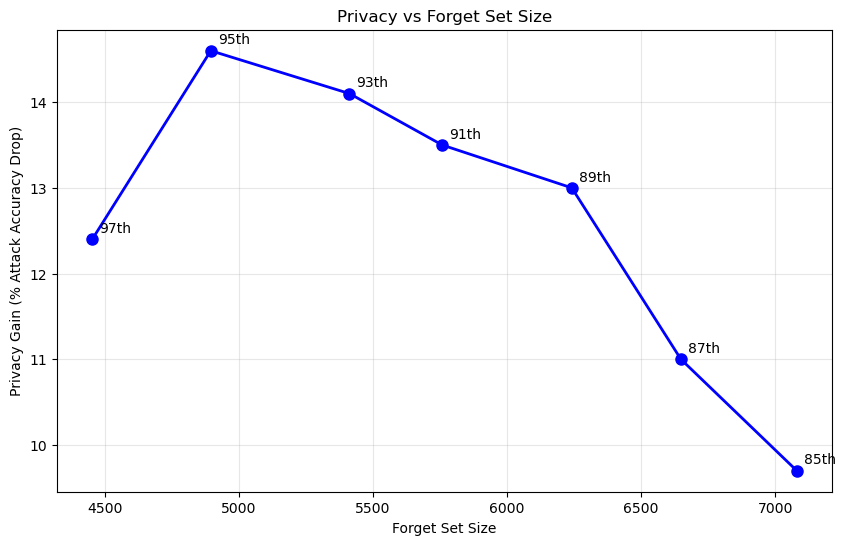

In [98]:
privacy_gains = [9.7, 11, 13, 13.5, 14.1, 14.6, 12.4] 
forget_sizes = [7080, 6648, 6241, 5758, 5412, 4895, 4453]  
percentiles = ['85th','87th','89th', '91th', '93th', '95th','97th']

plt.figure(figsize=(10, 6))
plt.plot(forget_sizes, privacy_gains, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Forget Set Size')
plt.ylabel('Privacy Gain (% Attack Accuracy Drop)')
plt.title('Privacy vs Forget Set Size')
plt.grid(True, alpha=0.3)

for i, (x, y, label) in enumerate(zip(forget_sizes, privacy_gains, percentiles)):
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points')

plt.show()

In [99]:
scenarios = [
   {'random_seed': 42, 'forget_percentile': 0.85},
   {'random_seed': 123, 'forget_percentile': 0.87},
   {'random_seed': 456, 'forget_percentile': 0.89},
   {'random_seed': 789, 'forget_percentile': 0.91},
   {'random_seed': 999, 'forget_percentile': 0.93},
   {'random_seed': 111, 'forget_percentile': 0.95},
   {'random_seed': 333, 'forget_percentile': 0.97}
]

all_results = []

for scenario in scenarios:
    results = run_pipeline(scenario)
    all_results.append({
    'seed': scenario['random_seed'],
    'percentile': f"{scenario['forget_percentile']*100:.0f}th",
    'forget_size': len(results['forget_set']),
    'original_attack': f"{results['target_accuracy']*100:.1f}%",
    'unlearned_attack': f"{results['unlearn_accuracy']*100:.1f}%",
    'improvement': f"{(results['target_accuracy']-results['unlearn_accuracy'])*100:.1f}%"
})

df = pd.DataFrame(all_results)
print(df)

   seed percentile  forget_size original_attack unlearned_attack improvement
0    42       85th         7080           63.0%            53.3%        9.7%
1   123       87th         6648           63.1%            52.1%       11.0%
2   456       89th         6241           63.7%            50.7%       13.0%
3   789       91th         5758           63.1%            49.6%       13.5%
4   999       93th         5412           62.8%            48.7%       14.1%
5   111       95th         4895           61.4%            46.8%       14.6%
6   333       97th         4453           60.0%            47.6%       12.4%


Current Verification Challenges:

Most methods only test one type of attack (usually basic MIA)
Limited evaluation on different data types/models
No standardized benchmarks for "how unlearned is unlearned enough?"
What's the privacy-utility tradeoff curve?